In [1]:
import numpy as np
from scipy.spatial import Delaunay
from sklearn.decomposition import PCA
from itertools import combinations
from tqdm import tqdm
import pandas as pd
import os
import pickle
from collections import Counter
from scipy.stats import gaussian_kde


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.tri as mtri
import matplotlib.cm as cm
matplotlib.rcParams['figure.dpi'] = 360
matplotlib.rcParams['text.usetex'] = True
os.environ['PATH'] = '/Library/TeX/texbin:' + os.environ['PATH']

In [2]:
def rotate_pca_3d(df):
    # use only the real points to calculate the PCA
    coords_real = df[~df['RAN']][['X', 'Y', 'Z']].values

    pca = PCA(n_components=3)
    pca.fit(coords_real)  # only reals define the orientation

    coords_all = df[['X', 'Y', 'Z']].values
    coords_rotated = pca.transform(coords_all)

    df_rot = df.copy()
    df_rot[['PC1', 'PC2', 'PC3']] = coords_rotated
    #df_rot['Angle rotation [°]'] = np.degrees(np.arccos(np.clip(pca.components_[0] @ [0, 0, 1], -1, 1)))

    return df_rot

In [3]:
def compute_r(df):
    coords = df[['X', 'Y', 'Z']].values
    is_data = ~df['RAN'].values

    tri = Delaunay(coords)

    #! adjacency list for neighbors
    neighbors = {i: set() for i in range(len(coords))}
    for simplex in tri.simplices:
        for i, j in combinations(simplex, 2):
            neighbors[i].add(j)
            neighbors[j].add(i)

    r = np.zeros(len(coords), dtype=float)
    for i, nbrs in neighbors.items():
        n_data = int(np.sum(is_data[list(nbrs)]))
        n_rand = len(nbrs) - n_data
        if (n_data + n_rand) > 0:
            r[i] = (n_data - n_rand) / (n_data + n_rand)
        else:
            raise ValueError(f'No neighbors for point {i} in the triangulation.')

    out = df.copy()
    out['r'] = r
    return out

In [4]:
def classify_r(df):
    r = df['r'].values
    conds = [(r >= -1.0) & (r <= -0.9),
             (r > -0.9) & (r <= 0.0),
             (r > 0.0) & (r <= 0.9),
             (r > 0.9) & (r <= 1.0),]
    choices = ['void', 'sheet', 'filament', 'knot']
    df = df.copy()
    df['TYPE'] = np.select(conds, choices, default='error')
    return df

### Data

In [5]:
# Base file paths
base_url_data = 'create_files/'
base_url_rand = 'data_100_random/'

In [6]:
data_filenames = [f'{base_url_data}QSO_{i}_clustering_data.ecsv' for i in range(20)]

In [7]:
# Structure to store the 100 df per rosette
# df_typed_all[i][j] is the dataframe of rosette i with random j
df_typed_all = [[None for _ in range(100)] for _ in range(20)]

In [13]:
for i in tqdm(range(20), desc="Rosettas"):
    # Read real data only once per rosette
    data_file = data_filenames[i]
    data = pd.read_csv(data_file, comment='#', sep=r'\s+', engine='python')
    data['RAN'] = False
    data['ROSETTE_ID'] = i

    for j in range(100):
        rand_file = f'{base_url_rand}QSO_{i}_clustering_random_{j}.ecsv'
        rand = pd.read_csv(rand_file, comment='#', sep=r'\s+', engine='python')
        rand['RAN'] = True
        rand['ROSETTE_ID'] = i

        # Concatenate real and random numbers
        df = pd.concat([data, rand], ignore_index=True)

        # PCA rotation
        df_rot = rotate_pca_3d(df)

        # Calculate r and classify
        df_r = compute_r(df_rot)
        df_typed = classify_r(df_r)
        df_typed_all[i][j] = df_typed  

Rosettas: 100%|██████████| 20/20 [03:36<00:00, 10.81s/it]


In [ ]:
# To SAVE the result in a file and not have to recalculate it
"""
with open('df_typed_all.pkl', 'wb') as f:
    pickle.dump(df_typed_all, f)
"""

# To READ the result and not have to recalculate it

"""
with open('df_typed_all.pkl', 'rb') as f:
    df_typed_all = pickle.load(f)
"""


# For verify

In [ ]:
for i in range(len(data_filenames)):

    rosetta_idx = i  # Rosetta 
    n_randoms_to_plot = 100 # random number

    plt.figure(figsize=(10, 8))

    # Real data (RAN == False)
    df_real = df_typed_all[rosetta_idx][0]  # we use any random because the real data is the same
    df_real = df_real[df_real['RAN'] == False]
    plt.scatter(df_real['PC1'], df_real['PC2'], color='black', label='Data (real)', s=10)

    # Randam data (RAN == True)
    for j in range(n_randoms_to_plot):
        df_rand = df_typed_all[rosetta_idx][j]
        if df_rand is not None:
            df_rand = df_rand[df_rand['RAN'] == True]
            plt.scatter(df_rand['PC1'], df_rand['PC2'], alpha=0.3, s=8)

    plt.xlabel('PC1 [Mpc]')
    plt.ylabel('PC2 [Mpc]')
    plt.title(f'Rosetta {rosetta_idx}: Real vs 10 random samples')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Type classification

In [9]:
structure_types = ['void', 'sheet', 'filament', 'knot']

In [10]:
data_fractions = {i: {t: [] for t in structure_types} for i in range(20)} # RAN == False
rand_fractions = {i: {t: [] for t in structure_types} for i in range(20)} # RAN == True

In [11]:
for i in range(20):  # Rosettas
    for j in range(100):  # Randoms
        df = df_typed_all[i][j]

        for source, container in [(False, data_fractions), (True, rand_fractions)]:
            df_sub = df[df['RAN'] == source]
            total = len(df_sub)

            for t in structure_types:
                count = np.sum(df_sub['TYPE'] == t)
                frac = count / total if total > 0 else 0.0
                container[i][t].append(frac)

In [12]:
# Table by rosette for data and rand with percentage values
dfs_by_rosetta = []

# Almacenes para promedios por tipo estructural
mean_data_by_type = {t: [] for t in structure_types}
mean_rand_by_type = {t: [] for t in structure_types}

for i in range(20):
    rosetta_rows = []
    rosetta_labels = []

    for label, container, store in [(f"Rosetta {i} data", data_fractions, mean_data_by_type),
                                     (f"Rosetta {i} rand", rand_fractions, mean_rand_by_type)]:
        row = []
        for t in structure_types:
            fracs = container[i][t]
            if len(fracs) == 0:
                mean_frac = 0.0
                std_frac = 0.0
            else:
                mean_frac = np.mean(fracs)
                std_frac = np.std(fracs, ddof=1)

            # Save mean value for summary 
            store[t].append(mean_frac)

            row.append(f"{mean_frac*100:.2f}% ± {std_frac*100:.2f}%")

        rosetta_rows.append(row)
        rosetta_labels.append(label)

    df_rosetta = pd.DataFrame(rosetta_rows,
                              columns=['Voids', 'Sheets', 'Filaments', 'Knots'],
                              index=rosetta_labels)
    dfs_by_rosetta.append(df_rosetta)

# Create an average summary table over the 20 rosettas
summary_rows = []

for label, store in [("Mean data", mean_data_by_type),
                     ("Mean rand", mean_rand_by_type)]:
    row = []
    for t in structure_types:
        means = store[t]  # 20 values
        avg = np.mean(means)
        err = np.std(means, ddof=1)  
        row.append(f"{avg*100:.2f}% ± {err*100:.2f}%")
    summary_rows.append(row)

df_summary = pd.DataFrame(summary_rows,
                          columns=['Voids', 'Sheets', 'Filaments', 'Knots'],
                          index=['Mean data', 'Mean rand'])


In [13]:
print("\n Summary across all Rosettas")
display(df_summary)


 Summary across all Rosettas


,Voids,Sheets,Filaments,Knots
Mean data,0.04% ± 0.01%,54.45% ± 0.70%,45.42% ± 0.69%,0.09% ± 0.02%
Mean rand,0.07% ± 0.02%,59.89% ± 0.63%,40.00% ± 0.64%,0.03% ± 0.01%


In [14]:
for i, rosetta_df in enumerate(dfs_by_rosetta):
    print(f"\nRosetta {i}")
    display(rosetta_df)


Rosetta 0


,Voids,Sheets,Filaments,Knots
Rosetta 0 data,0.05% ± 0.05%,54.85% ± 1.50%,45.02% ± 1.49%,0.07% ± 0.08%
Rosetta 0 rand,0.06% ± 0.07%,58.79% ± 1.28%,41.12% ± 1.28%,0.03% ± 0.04%



Rosetta 1


,Voids,Sheets,Filaments,Knots
Rosetta 1 data,0.06% ± 0.07%,55.09% ± 1.29%,44.76% ± 1.26%,0.09% ± 0.08%
Rosetta 1 rand,0.05% ± 0.06%,60.77% ± 1.12%,39.15% ± 1.13%,0.03% ± 0.05%



Rosetta 2


,Voids,Sheets,Filaments,Knots
Rosetta 2 data,0.05% ± 0.05%,53.62% ± 1.12%,46.27% ± 1.11%,0.06% ± 0.06%
Rosetta 2 rand,0.10% ± 0.07%,59.64% ± 1.09%,40.23% ± 1.10%,0.03% ± 0.05%



Rosetta 3


,Voids,Sheets,Filaments,Knots
Rosetta 3 data,0.04% ± 0.04%,53.66% ± 1.22%,46.20% ± 1.20%,0.10% ± 0.08%
Rosetta 3 rand,0.11% ± 0.08%,60.60% ± 1.12%,39.26% ± 1.11%,0.04% ± 0.05%



Rosetta 4


,Voids,Sheets,Filaments,Knots
Rosetta 4 data,0.06% ± 0.05%,52.77% ± 1.11%,47.06% ± 1.12%,0.11% ± 0.08%
Rosetta 4 rand,0.10% ± 0.07%,60.69% ± 1.08%,39.17% ± 1.08%,0.05% ± 0.05%



Rosetta 5


,Voids,Sheets,Filaments,Knots
Rosetta 5 data,0.04% ± 0.06%,55.49% ± 1.23%,44.36% ± 1.23%,0.11% ± 0.07%
Rosetta 5 rand,0.05% ± 0.05%,59.85% ± 1.10%,40.06% ± 1.09%,0.03% ± 0.04%



Rosetta 6


,Voids,Sheets,Filaments,Knots
Rosetta 6 data,0.03% ± 0.04%,54.91% ± 1.30%,45.02% ± 1.30%,0.03% ± 0.04%
Rosetta 6 rand,0.07% ± 0.08%,59.39% ± 0.98%,40.52% ± 0.97%,0.02% ± 0.04%



Rosetta 7


,Voids,Sheets,Filaments,Knots
Rosetta 7 data,0.05% ± 0.06%,54.25% ± 1.27%,45.66% ± 1.25%,0.05% ± 0.06%
Rosetta 7 rand,0.06% ± 0.07%,58.52% ± 1.29%,41.39% ± 1.29%,0.03% ± 0.04%



Rosetta 8


,Voids,Sheets,Filaments,Knots
Rosetta 8 data,0.03% ± 0.04%,53.97% ± 1.20%,45.88% ± 1.20%,0.11% ± 0.08%
Rosetta 8 rand,0.11% ± 0.09%,59.96% ± 1.04%,39.90% ± 1.05%,0.04% ± 0.05%



Rosetta 9


,Voids,Sheets,Filaments,Knots
Rosetta 9 data,0.03% ± 0.04%,54.80% ± 1.29%,45.07% ± 1.27%,0.10% ± 0.08%
Rosetta 9 rand,0.07% ± 0.07%,59.96% ± 1.18%,39.94% ± 1.18%,0.03% ± 0.05%



Rosetta 10


,Voids,Sheets,Filaments,Knots
Rosetta 10 data,0.05% ± 0.06%,54.52% ± 1.45%,45.36% ± 1.44%,0.07% ± 0.06%
Rosetta 10 rand,0.08% ± 0.08%,59.33% ± 1.29%,40.57% ± 1.29%,0.03% ± 0.04%



Rosetta 11


,Voids,Sheets,Filaments,Knots
Rosetta 11 data,0.04% ± 0.05%,54.23% ± 1.48%,45.63% ± 1.47%,0.09% ± 0.09%
Rosetta 11 rand,0.06% ± 0.06%,60.06% ± 1.15%,39.84% ± 1.16%,0.04% ± 0.05%



Rosetta 12


,Voids,Sheets,Filaments,Knots
Rosetta 12 data,0.04% ± 0.05%,54.12% ± 1.37%,45.75% ± 1.40%,0.10% ± 0.09%
Rosetta 12 rand,0.07% ± 0.07%,59.60% ± 1.30%,40.30% ± 1.30%,0.03% ± 0.04%



Rosetta 13


,Voids,Sheets,Filaments,Knots
Rosetta 13 data,0.04% ± 0.05%,54.21% ± 1.42%,45.61% ± 1.42%,0.13% ± 0.08%
Rosetta 13 rand,0.08% ± 0.09%,60.78% ± 1.15%,39.11% ± 1.15%,0.03% ± 0.04%



Rosetta 14


,Voids,Sheets,Filaments,Knots
Rosetta 14 data,0.03% ± 0.04%,53.91% ± 1.20%,45.96% ± 1.19%,0.10% ± 0.06%
Rosetta 14 rand,0.07% ± 0.07%,60.56% ± 1.17%,39.33% ± 1.17%,0.03% ± 0.04%



Rosetta 15


,Voids,Sheets,Filaments,Knots
Rosetta 15 data,0.04% ± 0.05%,54.60% ± 1.37%,45.27% ± 1.35%,0.09% ± 0.08%
Rosetta 15 rand,0.08% ± 0.08%,59.98% ± 1.11%,39.91% ± 1.10%,0.04% ± 0.04%



Rosetta 16


,Voids,Sheets,Filaments,Knots
Rosetta 16 data,0.04% ± 0.04%,54.96% ± 1.42%,44.94% ± 1.40%,0.06% ± 0.06%
Rosetta 16 rand,0.06% ± 0.06%,59.69% ± 1.14%,40.21% ± 1.15%,0.04% ± 0.04%



Rosetta 17


,Voids,Sheets,Filaments,Knots
Rosetta 17 data,0.05% ± 0.05%,54.70% ± 1.33%,45.20% ± 1.34%,0.05% ± 0.06%
Rosetta 17 rand,0.07% ± 0.06%,59.32% ± 1.27%,40.59% ± 1.27%,0.03% ± 0.04%



Rosetta 18


,Voids,Sheets,Filaments,Knots
Rosetta 18 data,0.03% ± 0.05%,54.56% ± 1.29%,45.30% ± 1.29%,0.10% ± 0.08%
Rosetta 18 rand,0.08% ± 0.08%,60.19% ± 1.22%,39.69% ± 1.22%,0.04% ± 0.05%



Rosetta 19


,Voids,Sheets,Filaments,Knots
Rosetta 19 data,0.05% ± 0.06%,55.86% ± 1.25%,44.00% ± 1.25%,0.09% ± 0.08%
Rosetta 19 rand,0.05% ± 0.05%,60.23% ± 1.26%,39.70% ± 1.27%,0.03% ± 0.04%


# Entropy
$
H = - \frac{1}{\log_2 4} \sum_{w=1}^4 p_w \log_2(p_w)
$

In [15]:
type_to_index = {t: i for i, t in enumerate(structure_types)}
type_to_index

{'void': 0, 'sheet': 1, 'filament': 2, 'knot': 3}

In [16]:
entropy_per_rosetta = []

for i in tqdm(range(20), desc="Rosettas"):
    df_real = df_typed_all[i][0]
    df_real = df_real[df_real['RAN'] == False].copy()
    n_points = len(df_real)

    counts = np.zeros((n_points, 4), dtype=int)

    for j in range(100):
        df_j = df_typed_all[i][j]
        if df_j is None:
            continue

        df_j_real = df_j[df_j['RAN'] == False].reset_index(drop=True)
        types_j = df_j_real['TYPE'].values

        # counter of the corresponding type for each point
        for idx, t in enumerate(types_j):
            if t in type_to_index:
                t_idx = type_to_index[t] # index of the type
                counts[idx, t_idx] += 1 # # add to that type's counter

    entropy_list = []

    # we go through each real point
    for idx in range(n_points):
        total = counts[idx].sum() # total times this point was ranked

        # we calculate probabilities by type (p_w)
        p_w = counts[idx] / total
        # we calculate normalized Shannon entropy (we use only p > 0 to avoid log(0))
        entropy = -np.sum(p_w[p_w > 0] * np.log2(p_w[p_w > 0])) / np.log2(4)

        point = df_real.iloc[idx]
        entropy_list.append({
            'TARGETID': point['TARGETID'],
            'ROSETTE_ID': i,
            'ENTROPY': entropy
        })

    entropy_df = pd.DataFrame(entropy_list)
    entropy_per_rosetta.append(entropy_df)

Rosettas: 100%|██████████| 20/20 [00:05<00:00,  3.44it/s]


In [19]:
with open('C:/Users/intercall/Desktop/DESI PROJECT/DR1/entropy_per_rosetta.pkl', 'wb') as f:
    pickle.dump(entropy_per_rosetta, f)

In [ ]:
for i in range(20):
    df = entropy_per_rosetta[i]
    entropy_values = df['ENTROPY'].dropna()

    hist, bin_edges = np.histogram(entropy_values, bins=16, range=(0, 0.6), density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    plt.plot(bin_centers, hist, label=f'Rosetta {i}', linewidth=1.5)
    plt.xlabel("Normalized Shannon Entropy", fontsize=14)
    plt.ylabel("PDF", fontsize=14)
    plt.grid(True)
    plt.legend(loc='center left', fontsize=8)
    plt.tight_layout()

plt.title("QSO")
plt.show()


# Groups

In [30]:
def find_friends(first_id, all_ids, pair_ids, included_ids):
    group = []
    #print(first_id) 
    #print(all_ids)
    loc = np.where(all_ids==first_id)[0][0]
    #print('firstid', first_id, 'loc', loc)
    if included_ids[loc] == 1: # caso base, el punto ya esta incluido
        return group
    else:
        # si no esta incluido, lo incluyo
        group.append(first_id)
        included_ids[loc] = 1
    
        # ahora busco los amigos
        friends = []
        friends += list(pair_ids[pair_ids[:,0]==first_id,1])
        friends += list(pair_ids[pair_ids[:,1]==first_id,0])
        #print('friends', friends)
        for friend in friends:
            group.append(friend)
            group.extend(find_friends(friend, all_ids, pair_ids, included_ids))
    
        group = list(set(group))
        group.sort()
        return group

In [31]:
def find_fof_groups(pairs):
    pairs = np.int_(pairs)
    #print(pairs)
    groups = {}
    group_id = 0
    all_ids = list(np.sort(np.unique(pairs.flatten())))
    n_points = len(all_ids)
    #print(n_points)
    print('points to be grouped',n_points)
    included_ids = list(np.zeros(n_points, dtype=int))

    n_total = 0
    for first_id in all_ids:
        fof_ids = find_friends(first_id, all_ids, pairs, included_ids)
        if len(fof_ids):
            #if len(fof_ids)>8:
            #    print(first_id, len(fof_ids))
            n_total += len(fof_ids)
            groups[group_id] = fof_ids
            group_id += 1
            
    # sanity check
    assert n_total == n_points
    return groups

In [32]:
def inertia_tensor(x, y, z):
    x = x - np.mean(x)
    y = y - np.mean(y)
    z = z - np.mean(z)
    r = np.sqrt(x**2 + y**2 + z**2)
    I = np.ones((3,3))
    
    I[0,0] = np.sum(r**2 - x*x)
    I[1,1] = np.sum(r**2 - y*y)
    I[2,2] = np.sum(r**2 - z*z)
    
    I[0,1] = -np.sum(x*y)
    I[1,0] = I[0,1]
    
    I[0,2] = -np.sum(x*z)
    I[2,0] = I[0,2]
    
    I[1,2] = -np.sum(y*z)
    I[2,1] = I[1,2]
    
    values, vectors = np.linalg.eig(I)
    ii = np.argsort(-values)
    #print(values[ii], len(x))
    return np.sqrt(values[ii]), vectors[:,ii]


In [76]:
def compute_group_properties(groups, positions):
    props = {}
    props['N'] = []
    props['MEAN_X'] = []; props['MEAN_Y'] = []; props['MEAN_Z'] = []
    props['SIGMA_X'] = []; props['SIGMA_Y'] = []; props['SIGMA_Z'] = []
    props['SIGMA_R'] = []
    props['LAMBDA_1'] = []; props['LAMBDA_2'] = []; props['LAMBDA_3'] = []
    props['EIGEN_1'] = []; props['EIGEN_2'] = []; props['EIGEN_3'] = []
    
    for i in groups.keys():
        x = positions[groups[i],0]
        y = positions[groups[i],1]
        z = positions[groups[i],2]
        r = np.sqrt(x**2 + y**2 + z**2)
        
        if len(x)>4:
        
            props['N'].append(len(groups[i]))
            props['SIGMA_R'].append(np.std(r))
            props['MEAN_X'].append(np.mean(x))
            props['MEAN_Y'].append(np.mean(y))
            props['MEAN_Z'].append(np.mean(z))
            props['SIGMA_X'].append(np.std(x))
            props['SIGMA_Y'].append(np.std(y))
            props['SIGMA_Z'].append(np.std(z))        

            values, vectors = inertia_tensor(x,y,z)
            props['LAMBDA_1'].append(values[0])
            props['LAMBDA_2'].append(values[1])
            props['LAMBDA_3'].append(values[2])
            props['EIGEN_1'].append(vectors[:,0])
            props['EIGEN_2'].append(vectors[:,1])
            props['EIGEN_3'].append(vectors[:,2])

    return pd.DataFrame(props)

In [108]:
rosetta_number = 19
random_number = 48

type_class = 'knot'
random_or_data = False

#df_r = df_typed_all[rosetta_number][random_number]
#df_void_random = df_r[(df_r['RAN'] == random_or_data) & (df_r['TYPE'] == type_class)].reset_index(drop=True)

df_r_proof = df_typed_all_proof[rosetta_number][random_number]
df_void_random_proof = df_r_proof[(df_r_proof['RAN'] == random_or_data) & (df_r_proof['TYPE'] == type_class)].reset_index(drop=True)

#positions = df_void_random[['X', 'Y', 'Z']].values
positions_proof = df_void_random_proof[['X', 'Y', 'Z']].values

#n_points = len(positions)
n_points_proof = len(positions_proof)

#tri = Delaunay(positions)
tri_proof = Delaunay(positions_proof)

#pairs = set()
pairs_proof = set()
"""
for simplex in tri.simplices:
    for i, j in combinations(simplex, 2):
        if i != j:
            pairs.add(tuple(sorted((i, j))))
pairs = np.array(list(pairs))
"""
for simplex in tri_proof.simplices:
    for i, j in combinations(simplex, 2):
        if i != j:
            pairs_proof.add(tuple(sorted((i, j))))
pairs_proof = np.array(list(pairs_proof))

#groups = find_fof_groups(pairs)
groups_proof = find_fof_groups(pairs_proof)

#group_properties_df = compute_group_properties(groups, positions)
group_properties_df_proof = compute_group_properties(groups_proof, positions_proof) 


points to be grouped 62


In [104]:
group_properties_df

,N,MEAN_X,MEAN_Y,MEAN_Z,SIGMA_X,SIGMA_Y,SIGMA_Z,SIGMA_R,LAMBDA_1,LAMBDA_2,LAMBDA_3,EIGEN_1,EIGEN_2,EIGEN_3
0,687,-1917.398517,-2849.55105,3244.373817,426.460934,628.039355,707.099008,1033.035889,27136.56821,27126.55841,2565.313451,"[0.19550665994356867, 0.6727817519660876, 0.71...","[-0.8917989863073217, 0.4246649707787189, -0.1...","[-0.4080094532469841, -0.6058253682498099, 0.6..."


In [105]:
group_properties_df_proof

,N,MEAN_X,MEAN_Y,MEAN_Z,SIGMA_X,SIGMA_Y,SIGMA_Z,SIGMA_R,LAMBDA_1,LAMBDA_2,LAMBDA_3,EIGEN_1,EIGEN_2,EIGEN_3
0,641,-1914.348042,-2843.630685,3238.765633,425.761705,627.794178,707.881163,1033.125705,26213.659128,26205.727192,2483.873928,"[0.21901194056359014, 0.6620058981138258, 0.71...","[-0.8866280949057185, 0.4417111859473959, -0.1...","[-0.40733817794837224, -0.6055075714403935, 0...."


 Graficar grupos:

In [109]:
"""
df_void_random = df_void_random.copy()
df_void_random['group_id'] = -1
for gid, indices in groups.items():
    df_void_random.iloc[indices, df_void_random.columns.get_loc('group_id')] = gid
"""
df_void_random_proof = df_void_random_proof.copy()
df_void_random_proof['group_id'] = -1
for gid, indices in groups_proof.items():
    df_void_random_proof.iloc[indices, df_void_random_proof.columns.get_loc('group_id')] = gid

# Filtrar grupos con más de 5 miembros
#min_size = 5
#valid_groups = df_void_random['group_id'].value_counts().index
#valid_groups = valid_groups[valid_groups > min_size].index

valid_groups_proof = df_void_random_proof['group_id'].value_counts().index
#valid_groups_proof = valid_groups_proof[valid_groups_proof > min_size].index

C:\Users\intercall\AppData\Local\Temp\ipykernel_4004\3193828552.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_1 = cm.get_cmap('tab10', len(valid_groups))
C:\Users\intercall\AppData\Local\Temp\ipykernel_4004\3193828552.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_2 = cm.get_cmap('Set2', len(valid_groups_proof))


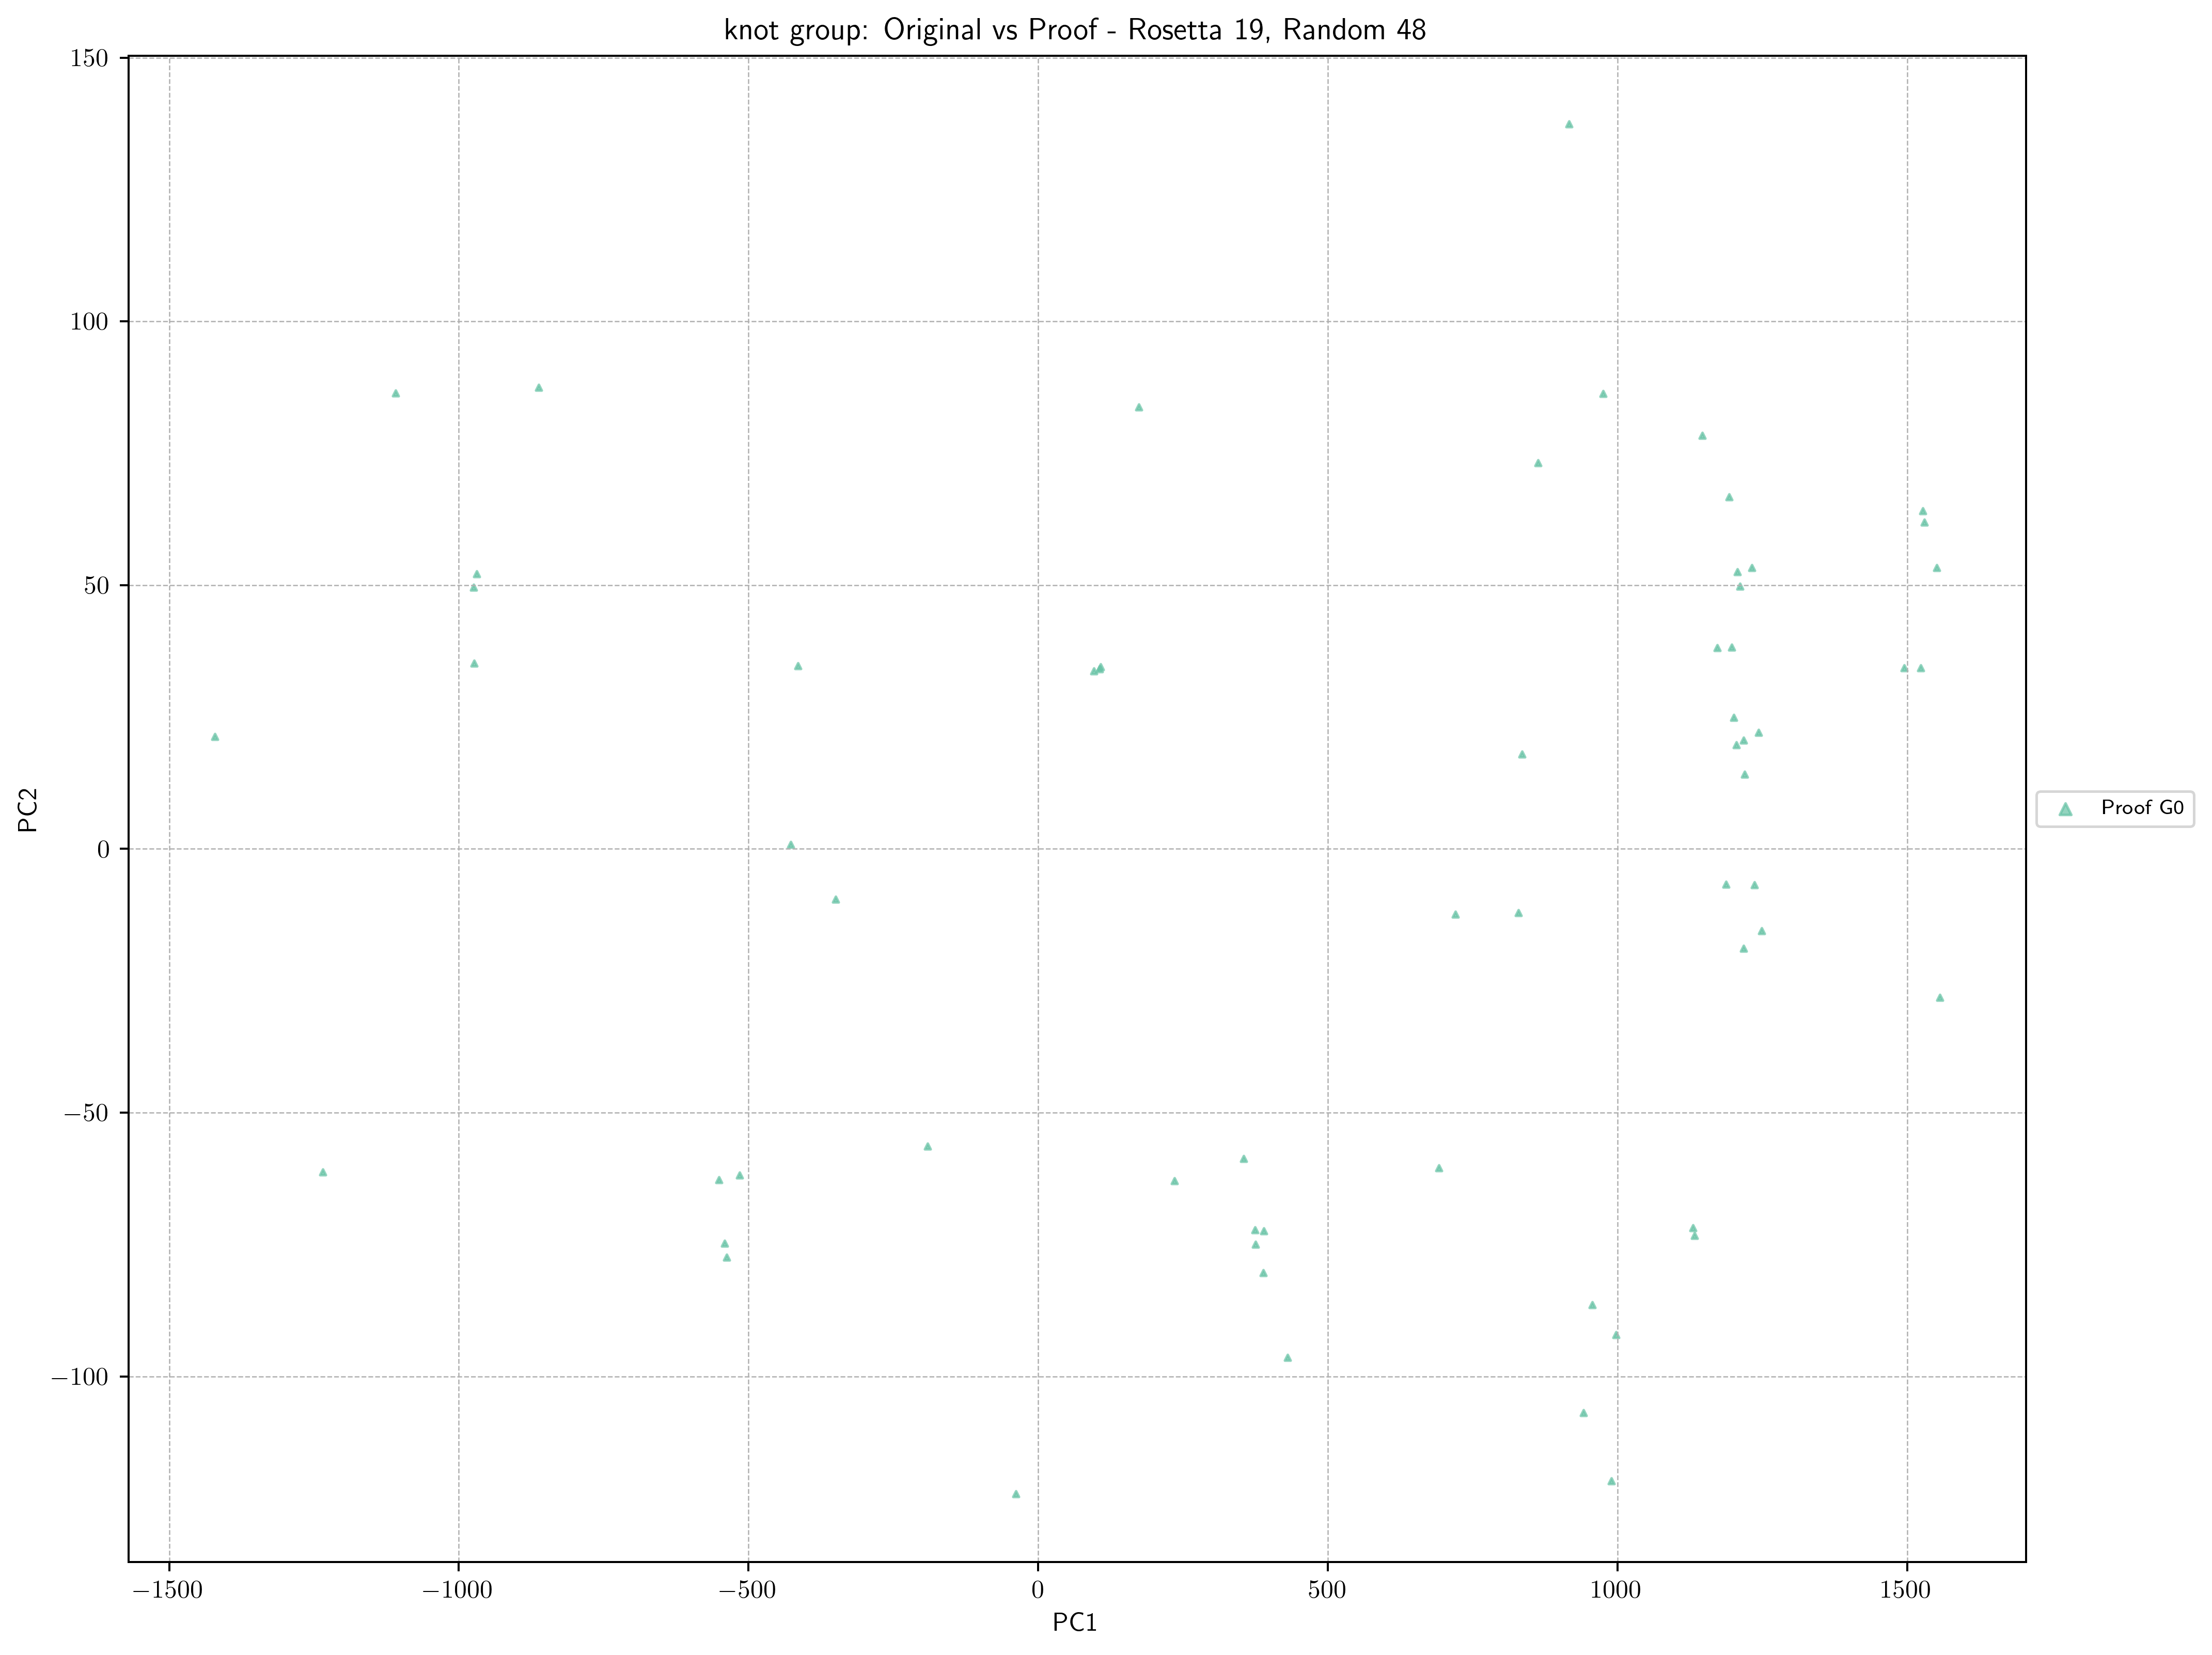

In [112]:
plt.figure(figsize=(12, 9))

colors_1 = cm.get_cmap('tab10', len(valid_groups))
colors_2 = cm.get_cmap('Set2', len(valid_groups_proof))

"""
# Graficar grupo original
for idx, gid in enumerate(valid_groups):
    grupo = df_void_random[df_void_random['group_id'] == gid]
    plt.scatter(grupo['PC1'], grupo['PC2'], s=20, color=colors_1(idx), label=f'Original G{gid}', alpha=0.7)
"""
# Graficar grupo proof
for idx, gid in enumerate(valid_groups_proof):
    grupo = df_void_random_proof[df_void_random_proof['group_id'] == gid]
    plt.scatter(grupo['PC1'], grupo['PC2'], s=5, color=colors_2(idx), marker='^', label=f'Proof G{gid}', alpha=0.7)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'{type_class} group: Original vs Proof - Rosetta {rosetta_number}, Random {random_number}')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(markerscale=2, fontsize=8, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()